In [30]:
from core import *
import os , random

directory = '/home/mmed/Documents/projects/bill_reader/data'
bill = random.choice(os.listdir(directory))
file =os.path.join(directory, bill)
file = '/home/mmed/Documents/projects/bill_reader/data/cowgirlcreamery-20190420_010.pdf'
# file = '/home/mmed/Documents/projects/bill_reader/data/applebees_8267120140431.pdf'

In [2]:
fig_size = plt.rcParams["figure.figsize"]

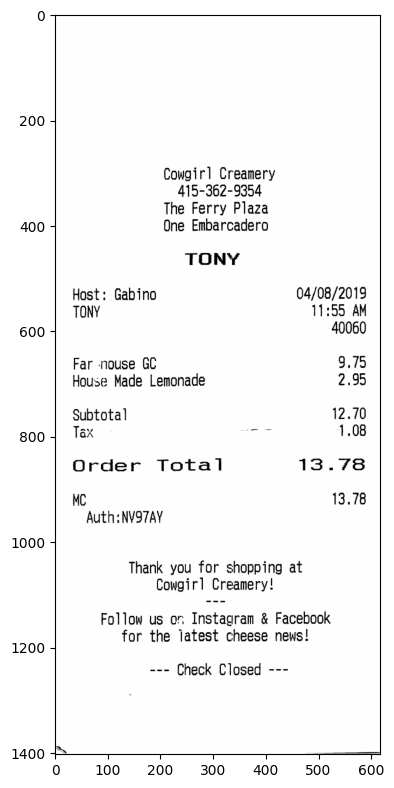

In [31]:
plt.rcParams["figure.figsize"] = [2 * x for x in fig_size]
image = get_image(file)
plt.imshow(image)
plt.show()

In [32]:
results = ts.image_to_data(image, 
output_type=Output.DICT)
df = pd.DataFrame(data= results)
df = df[df.text != '']
df = df.apply(clean_the_text,axis= 1)

In [33]:
product_lines = get_lines(df)

In [34]:
product_lines

{648: ['Far :nouse GC', '9.75'],
 681: ['House Made Lemonade', '2.95'],
 746: ['Subtotal', '12.70'],
 778: ['Tax -', '1.08'],
 843: ['Order Total', '13.78'],
 907: ['MC', '13.78']}

In [35]:
isolate_products(product_lines)
product_lines

{648: ['Far :nouse GC', '9.75'],
 681: ['House Made Lemonade', '2.95'],
 746: ['Subtotal', '12.70'],
 778: ['Tax -', '1.08'],
 843: ['Order Total', '13.78'],
 907: ['MC', '13.78']}

In [36]:
formats = []
for line in product_lines:
    formats.append(get_format(product_lines[line]))
print(most_frequent(formats))

['desc', 'price']


In [37]:
formats = []
for line in product_lines:
    formats.append(get_format(product_lines[line]))
chosen_format = most_frequent(formats)
product_list = pd.DataFrame(columns=chosen_format)
for line in product_lines:
    if follow_format(product_lines[line],chosen_format):
        product_list.loc[len(product_list.index)] = get_data(product_lines[line],chosen_format)
product_list


,desc,price
0,Far :nouse GC,9.75
1,House Made Lemonade,2.95
2,Subtotal,12.70
3,Tax -,1.08
4,Order Total,13.78
5,MC,13.78


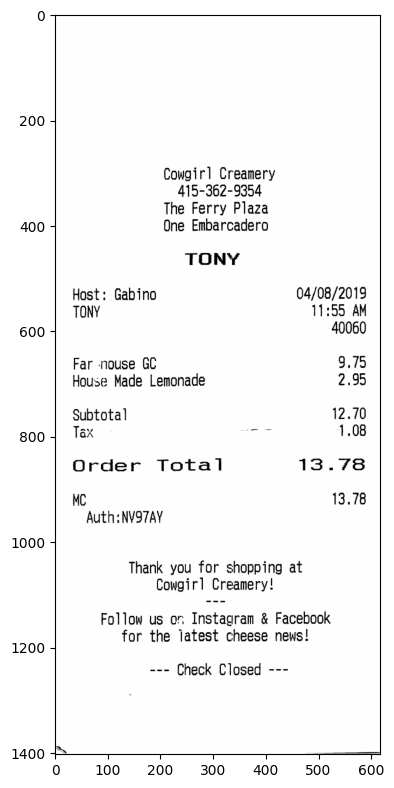

In [38]:
plt.rcParams["figure.figsize"] = [ 2 * x for x in fig_size]
image = get_image(file)
plt.imshow(image)
plt.show()